## Hiragana
use CNN to learn and recognize hiraggana


In [105]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pandas as pd
import random, math, os

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import RMSprop
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

#for CNN model
from keras.layers import Flatten
from keras.layers import Conv2D, MaxPooling2D


Import and organize data

In [106]:
## extract the romanji from a filename
import re
# hiragana-dataset-master/hiragana_images/kanaBA0.jpg
def get_romanji(filename):
    keyword = re.search(r'kana(\w+?)\d+', filename).group(1)
    return keyword.lower()


In [107]:
## import data into a list
## construct datatable

handwriting_list = []
dir_name = "hiragana-dataset-master/hiragana_images"
# os.listdir(dir_name)
for filename in os.listdir(dir_name):
    # print(f"{dir_name}/f{filename}.jpg")
    picture_label_list = [cv.imread(f"{dir_name}/{filename}", cv.IMREAD_GRAYSCALE), filename, get_romanji(filename)]
    handwriting_list.append(picture_label_list)
# print(handwriting_list)

handwriting_table = pd.DataFrame(handwriting_list, columns=["Handwriting", "Filename", "Romanji"])
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU5.jpg,yu
996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU6.jpg,yu
997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU7.jpg,yu
998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaYU8.jpg,yu


## process the images


In [108]:
thresh = 40
def im_clean(img):
    ## remove noices
    img = cv.medianBlur(img, 3)
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_TOZERO)
    img = cv.GaussianBlur(img, (3,3), 0)
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_TOZERO)
    kernel = cv.getStructuringElement(cv.MORPH_CROSS, (3, 3))
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, -1)
    # img = cv.GaussianBlur(img,(9,9),0)
    # ret, img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel, iterations=1)
    # img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel, iterations=1)
    img = cv.erode(img, kernel, iterations=1)
    return img

def im_bin(img):
    ret, img = cv.threshold(img, thresh, 255, cv.THRESH_BINARY)
    return img


In [109]:
img_rows, img_cols = 84, 84

def im_reshape(img): # reshape the handwriting part into 64x64, in a 84x84 img. The surrounding border is consist of zeroes.
    ## construct 4x84 frme, reshape the handwrting part into 64x64
    fig = np.zeros((84, 84), dtype=np.uint8)
    c_axis = img.sum(axis=0)
    c_axis = np.nonzero(c_axis)[0]
    # print(c_axis)
    # c_min, c_max = c_axis[0], c_axis[-1]
    c_min, c_max = max(0, c_axis[0] - 5), min(img.shape[1], c_axis[-1] + 5)
    r_axis = img.sum(axis=1)
    r_axis = np.nonzero(r_axis)[0]
    # print(r_axis)
    # r_min, r_max = r_axis[0], r_axis[-1]
    r_min, r_max = max(0, r_axis[0] - 5), min(img.shape[0], r_axis[-1] + 5)
    img = img[r_min:r_max, c_min:c_max]
    img = cv.resize(img, (64, 64))
    fig[11:75, 11:75] = img
    return fig


In [110]:
handwriting_table.Handwriting = handwriting_table.Handwriting.map(lambda img: im_reshape(im_clean(img)))


## Import another dataset
Import a new dataset created by Wishyut.

In [111]:
handwriting_list_wishyut = []
dir_name_wishyut = "handwriting_wishyut"
for filename in os.listdir(dir_name_wishyut):
    picture_label_list = [cv.imread(f"{dir_name_wishyut}/{filename}", cv.IMREAD_GRAYSCALE), filename, re.search(r'_(\w+?)_', filename).group(1)]
    handwriting_list_wishyut.append(picture_label_list)

handwriting_table_wishyut = pd.DataFrame(handwriting_list_wishyut, columns=["Handwriting", "Filename", "Romanji"])
handwriting_table_wishyut.Handwriting = handwriting_table_wishyut.Handwriting.map(lambda img: im_reshape(im_bin(img)))


In [112]:
## combine two tables
handwriting_table = handwriting_table.append(handwriting_table_wishyut, ignore_index=True)
handwriting_table

,Handwriting,Filename,Romanji
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a
...,...,...,...
1400,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_5.png,yu
1401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_6.png,yu
1402,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_7.png,yu
1403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_8.png,yu


Organizing Romanji labels
* Organize the different labels with the same pronunciation

In [113]:
handwriting_table.loc[handwriting_table["Romanji"] == "hu", "Romanji"] = "fu"
handwriting_table.loc[handwriting_table["Romanji"] == "ti", "Romanji"] = "chi"


Add numerical label to each Romanji (for categorization)

In [141]:
## add labels to the datatable w.r.t. the romanji
def romanji_to_dict(S): # construct dict from Romanji series
    romanji_set = set (S)
    # romanji_list = list(set(S))
    romanji_dict = {}
    for i, romanji in enumerate(romanji_set):
        romanji_dict[romanji] = i
    return romanji_dict

romanji_dict = romanji_to_dict(handwriting_table["Romanji"])
romanji_categories = len(romanji_dict)
handwriting_table["Label"] = handwriting_table["Romanji"].map(lambda x: romanji_dict[x])

print(romanji_dict)
print(romanji_categories)

handwriting_table

{'ya': 0, 'to': 1, 'ne': 2, 'no': 3, 'shi': 4, 'ri': 5, 'se': 6, 'ku': 7, 'na': 8, 'he': 9, 'me': 10, 'mi': 11, 'ki': 12, 'ho': 13, 'hi': 14, 'n': 15, 'ta': 16, 'i': 17, 'wa': 18, 'ke': 19, 'ko': 20, 'ni': 21, 'pi': 22, 'ra': 23, 'ro': 24, 'sa': 25, 'fu': 26, 'te': 27, 'tsu': 28, 'o': 29, 'ma': 30, 'yu': 31, 'da': 32, 'su': 33, 'yo': 34, 'ru': 35, 'mu': 36, 'chi': 37, 'nu': 38, 'tu': 39, 'wo': 40, 'si': 41, 'ji': 42, 'ha': 43, 'ba': 44, 'ka': 45, 'a': 46, 'mo': 47, 're': 48, 'u': 49, 'e': 50, 'so': 51}
52


,Handwriting,Filename,Romanji,Label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA0.jpg,a,46
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA1.jpg,a,46
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA10.jpg,a,46
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA11.jpg,a,46
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",kanaA12.jpg,a,46
...,...,...,...,...
1400,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_5.png,yu,31
1401,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_6.png,yu,31
1402,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_7.png,yu,31
1403,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",train_yu_8.png,yu,31


In [115]:
## construct X and y data from data-table
X = handwriting_table["Handwriting"].to_numpy()
y = handwriting_table["Label"].to_numpy()
# X = X.reshape(X.shape[0], img_rows, img_cols, 1)
# print(X.shape[0])
# print(X[0].shape)
X = np.array([X[i].reshape(img_rows, img_cols) for i in range(X.shape[0])])
X = X.reshape(X.shape[0], img_rows, img_cols, 1)
X.shape

(1405, 84, 84, 1)

In [116]:
## split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #shuffle=True
Y_train = np_utils.to_categorical(y_train, romanji_categories)
Y_test = np_utils.to_categorical(y_test, romanji_categories)
X_train.shape

(1124, 84, 84, 1)

# Standardization
standardize the strength of each pixel from 0-255 to 0-1

In [117]:
## standardize X_train and X_test
def std_X(X):
    X = X.astype('float32') / 255
    return X

X_train = std_X(X_train)
X_test = std_X(X_test)

# CNN Model
Construct a CNN model with two convolution blocks, one flattening, and one dense layers.
* Each convolution block contains two convolution layers and a maxpooling layer.

In [118]:
input_shape = (img_rows, img_cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape,
                 padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(romanji_categories, activation='softmax'))

print('model.summary:')
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

model.summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 84, 84, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 84, 84, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 42, 42, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                   

# Augmentation
Use the augmentation to generate more data from the training data.
* Use rotate and shear transform to simulate all kinds of handwritings.

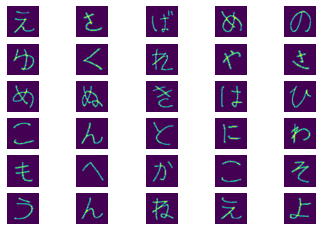

In [119]:
from keras.preprocessing.image import ImageDataGenerator

# Range for picking a value from.
datagen = ImageDataGenerator(
    rotation_range=5,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    shear_range=0.1,
    # zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2)


i = 0
for batch in datagen.flow(X_train, batch_size=1):
    plt.subplot(6,5,1 + i)
    plt.axis("off")
    
    augImage = batch[0]
    augImage = augImage.astype('float32')
    augImage /= 255
    plt.imshow(augImage)
    
    i += 1
    if i > 29:
        break

In [120]:
## train the model wuth data (including augmentaion datagen)
batch_size = 256  #128
nb_epoch = 16

# generate data with datagen
datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:
train_history = model.fit(datagen.flow(X_train, Y_train, batch_size=32, subset='training'),
         validation_data=datagen.flow(X_train, Y_train, batch_size=8, subset='validation'),
         batch_size=batch_size, epochs=nb_epoch, verbose=1,
         callbacks=EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode="auto"))


Epoch 1/16
29/29 [==============================] - 13s 411ms/step - loss: 2.5934 - accuracy: 0.3944 - val_loss: 0.5569 - val_accuracy: 0.8304
Epoch 2/16
29/29 [==============================] - 11s 389ms/step - loss: 0.3870 - accuracy: 0.8911 - val_loss: 0.4690 - val_accuracy: 0.8527
Epoch 3/16
29/29 [==============================] - 11s 391ms/step - loss: 0.1660 - accuracy: 0.9544 - val_loss: 0.2828 - val_accuracy: 0.9241
Epoch 4/16
29/29 [==============================] - 11s 391ms/step - loss: 0.1159 - accuracy: 0.9711 - val_loss: 0.1865 - val_accuracy: 0.9420
Epoch 5/16
29/29 [==============================] - 12s 399ms/step - loss: 0.0280 - accuracy: 0.9878 - val_loss: 0.2897 - val_accuracy: 0.9375
Epoch 6/16
29/29 [==============================] - 11s 388ms/step - loss: 0.0596 - accuracy: 0.9889 - val_loss: 0.1726 - val_accuracy: 0.9509
Epoch 7/16
29/29 [==============================] - 11s 392ms/step - loss: 0.0325 - accuracy: 0.9922 - val_loss: 0.1788 - val_accuracy: 0.9554

Plot the training process.

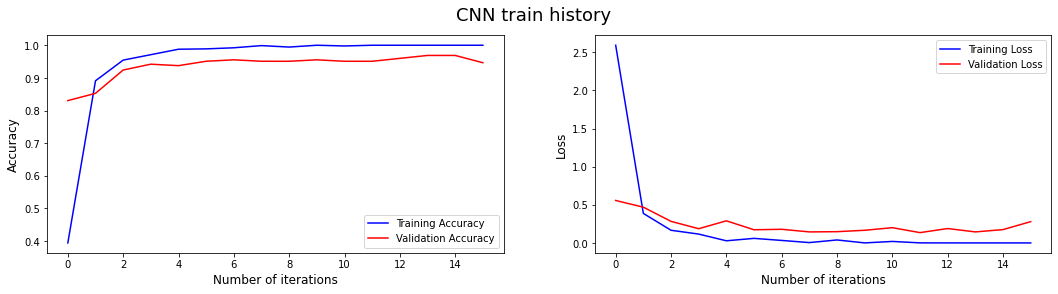

In [136]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(18,4))
plt.suptitle('CNN train history', fontsize=18)

ax1 = plt.subplot(1, 2, 1)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Number of iterations', fontsize=12)
plt.plot(train_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(train_history.history['val_accuracy'], color='r', label='Validation Accuracy')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='lower right')

ax2 = plt.subplot(1, 2, 2)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Number of iterations', fontsize=12)
plt.plot(train_history.history['loss'], color='b', label='Training Loss')
plt.plot(train_history.history['val_loss'], color='r', label='Validation Loss')
ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='upper right')
plt.show()

# Model Evaluation
Evaluate the model with testing data.

In [122]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

9/9 [==============================] - 1s 82ms/step - loss: 0.3227 - accuracy: 0.9715
Test score: 0.3226928412914276
Test accuracy: 0.9715302586555481


total testing data: 281
Number of errors = 8/281
Accuracy: 0.97


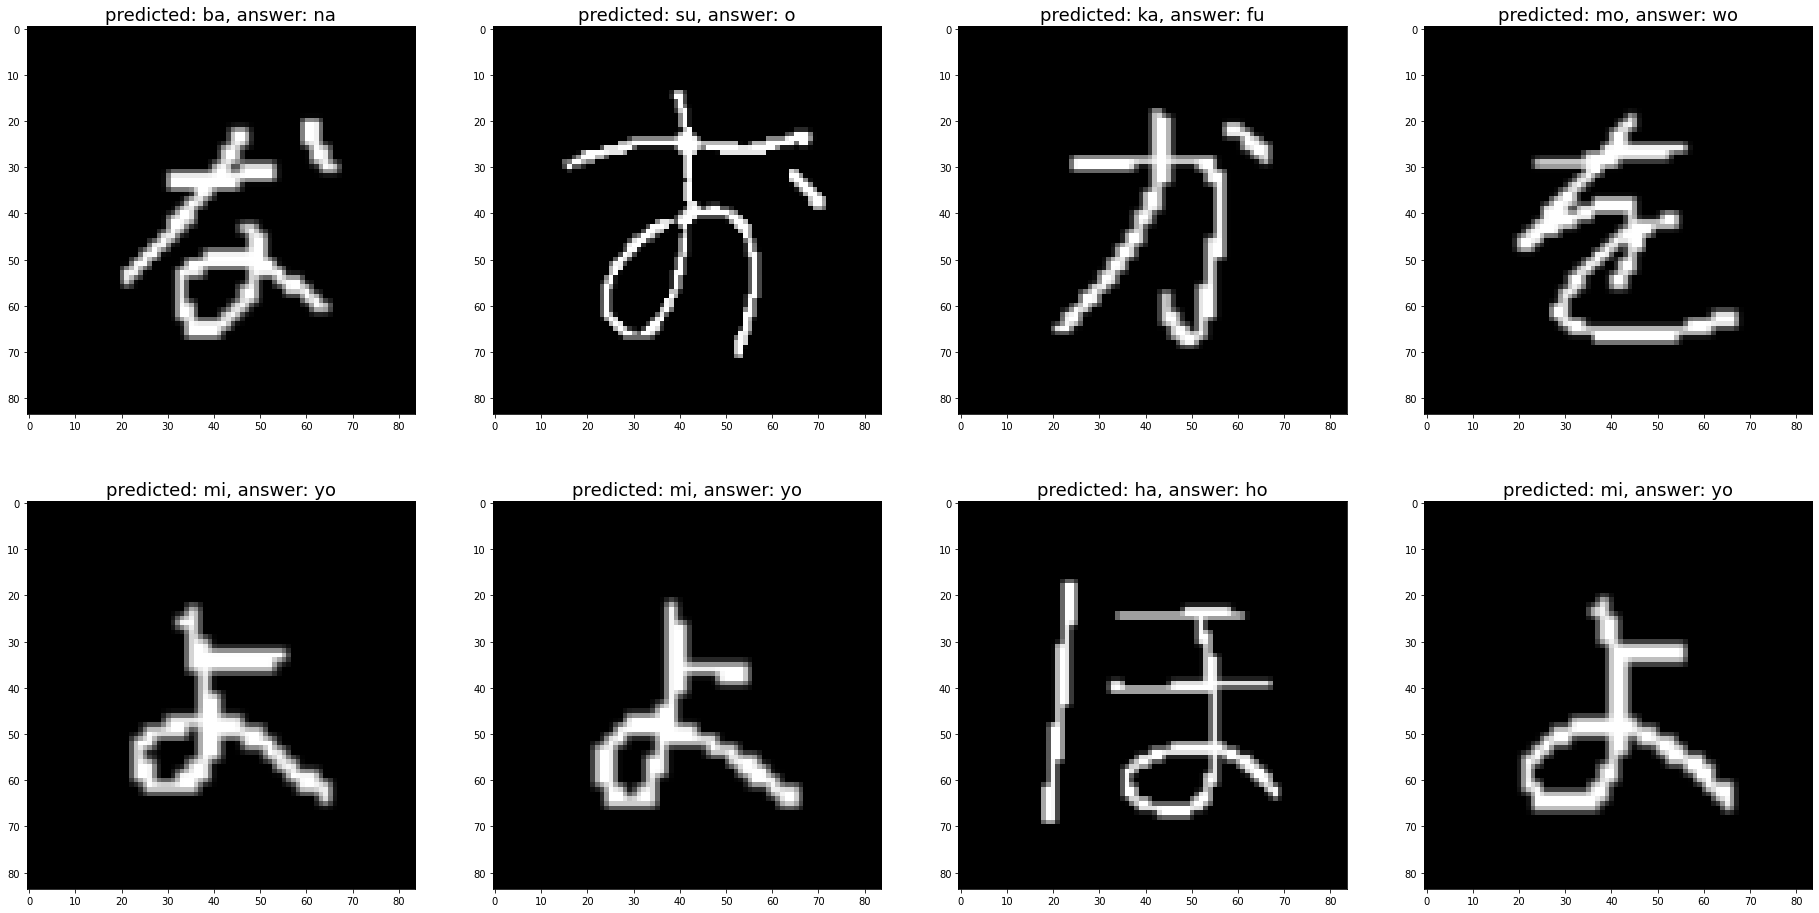

In [123]:
inv_romanji_dict = dict((v,k) for k,v in romanji_dict.items())

# print(inv_romanji_dict)

nVal = X_test.shape[0]
print(f"total testing data: {nVal}")
prob = model.predict(X_test)
# print(prob)
predictions=np.argmax(prob,axis=1)
# print(predictions)
ground_truth = y_test
# print(ground_truth)

## print errors
errors = np.where(predictions != ground_truth)[0]
# print(errors)
num_err = len(errors)
print("Number of errors = {}/{}".format(num_err,nVal))
print("Accuracy: {:.2f}".format(1-num_err/nVal))

num_eachrow = 4
rows_err = math.ceil(num_err / num_eachrow)
fig, axes = plt.subplots(rows_err, num_eachrow, figsize=(8*num_eachrow,8*rows_err))

for r in range(rows_err):
    for c in range(num_eachrow):
        n_err = r * num_eachrow + c
        if n_err >= num_err: break
        pos_err = errors[n_err]
        # plt.title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}")
        axes[r,c].set_title(f"predicted: {inv_romanji_dict[predictions[pos_err]]}, answer: {inv_romanji_dict[y_test[pos_err]]}", fontsize=18)
        axes[r,c].imshow(X_test[pos_err], cmap=plt.get_cmap('gray'))


## Confusion matrix


In [124]:
confusion_matrix = np.zeros((romanji_categories, romanji_categories), dtype=np.uint8)

for predict, answer in zip(predictions, ground_truth):
    confusion_matrix[answer][predict] += 1
confusion_matrix


array([[5, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 8]], dtype=uint8)

In [137]:
import itertools
# import matplotlib.axis as axis
import matplotlib

def geterr_confusion_matrix():
    pass

def plot_confusion_matrix(M, categories, title='Confusion matrix', normalize=False, cmap=plt.cm.Blues, figsize=(20,20)):
    ## normalize option
    if normalize:
        M = M.astype('float') / M.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(M)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(M, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=18)

    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("", rotation=-90, va="bottom")

    tick_marks = np.arange(categories)
    tick_labels = [inv_romanji_dict[i] for i in tick_marks]

    ax.xaxis.set_ticks(tick_marks) # rotation=45
    ax.xaxis.set_ticklabels(tick_labels)
    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(tick_labels)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.xaxis.set_label_position('top')

    # fmt = '{:.2f}' if normalize else '{:d}'
    thresh = M.max() / 2.
    for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
        value = M[i,j]
        if not normalize:
            value_str = "{:d}".format(value)
        else:
            if value == 0:
                value_str = "0"
            else:
                value_str = "{:.2f}".format(value)
        ax.text(j, i, value_str,
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if M[i, j] > thresh else "black")


Confusion matrix, without normalization
[[5 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 7 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 8]]


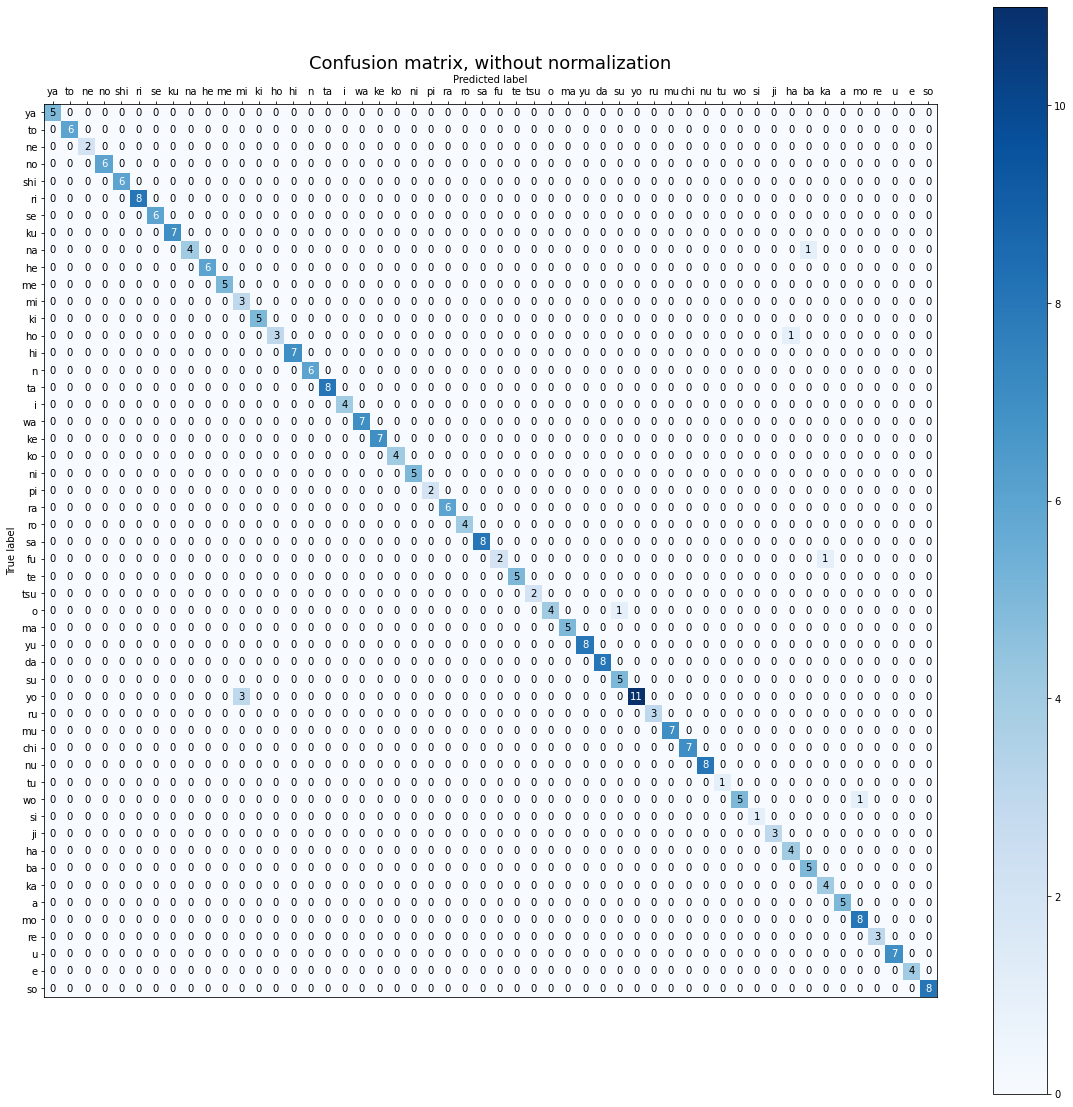

In [138]:
## plot confusion matrix (not normalized)
plot_confusion_matrix(confusion_matrix, romanji_categories,
                      title='Confusion matrix, without normalization')


Normalized confusion matrix
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


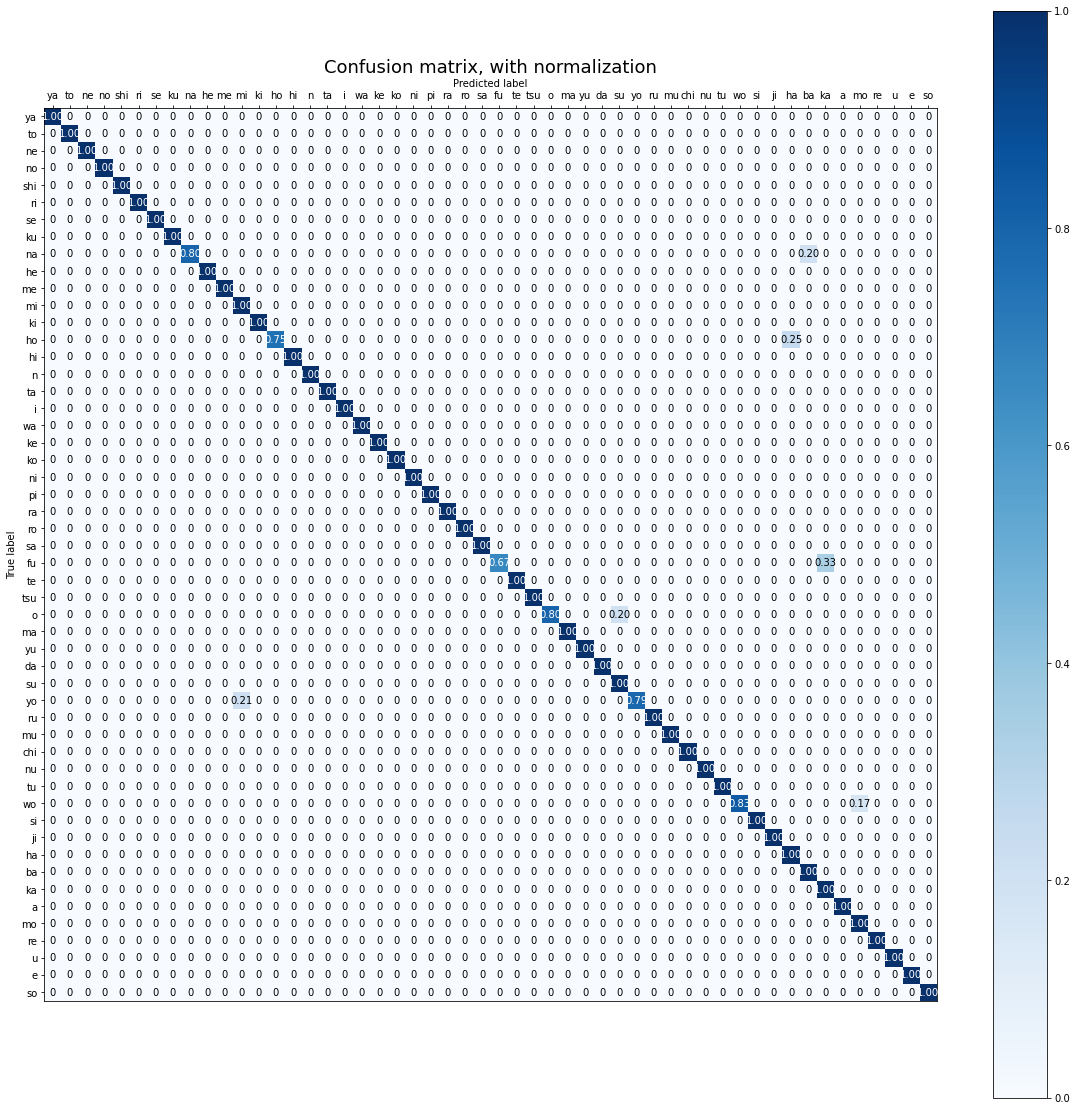

In [139]:
## plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, romanji_categories,
                      normalize=True,
                      title='Confusion matrix, with normalization')


## Test my handwritings
Write hiraganas with paint-2D (小畫家).

Test my hiragana handwritings with the trained model.

In [128]:
my_handwritings = []
answers_myhw = []
for file in os.listdir("test_my_handwriting"):
    # print(file)
    key = re.search(r'_(\w+?)_', file).group(1)
    # print(key, end=", ")
    answers_myhw.append(key)
    img = cv.imread(f"test_my_handwriting/{file}", cv.IMREAD_GRAYSCALE)
    img = 255 - img
    # print(img.shape)
    img = im_reshape(im_bin(img))
    my_handwritings.append(img)

my_handwritings = np.array(my_handwritings)
print(my_handwritings.shape)
# print(answers_myhw)

(92, 84, 84)


(92, 84, 84, 1)
Number of errors_myhw = 16/92
Accuracy: 0.83


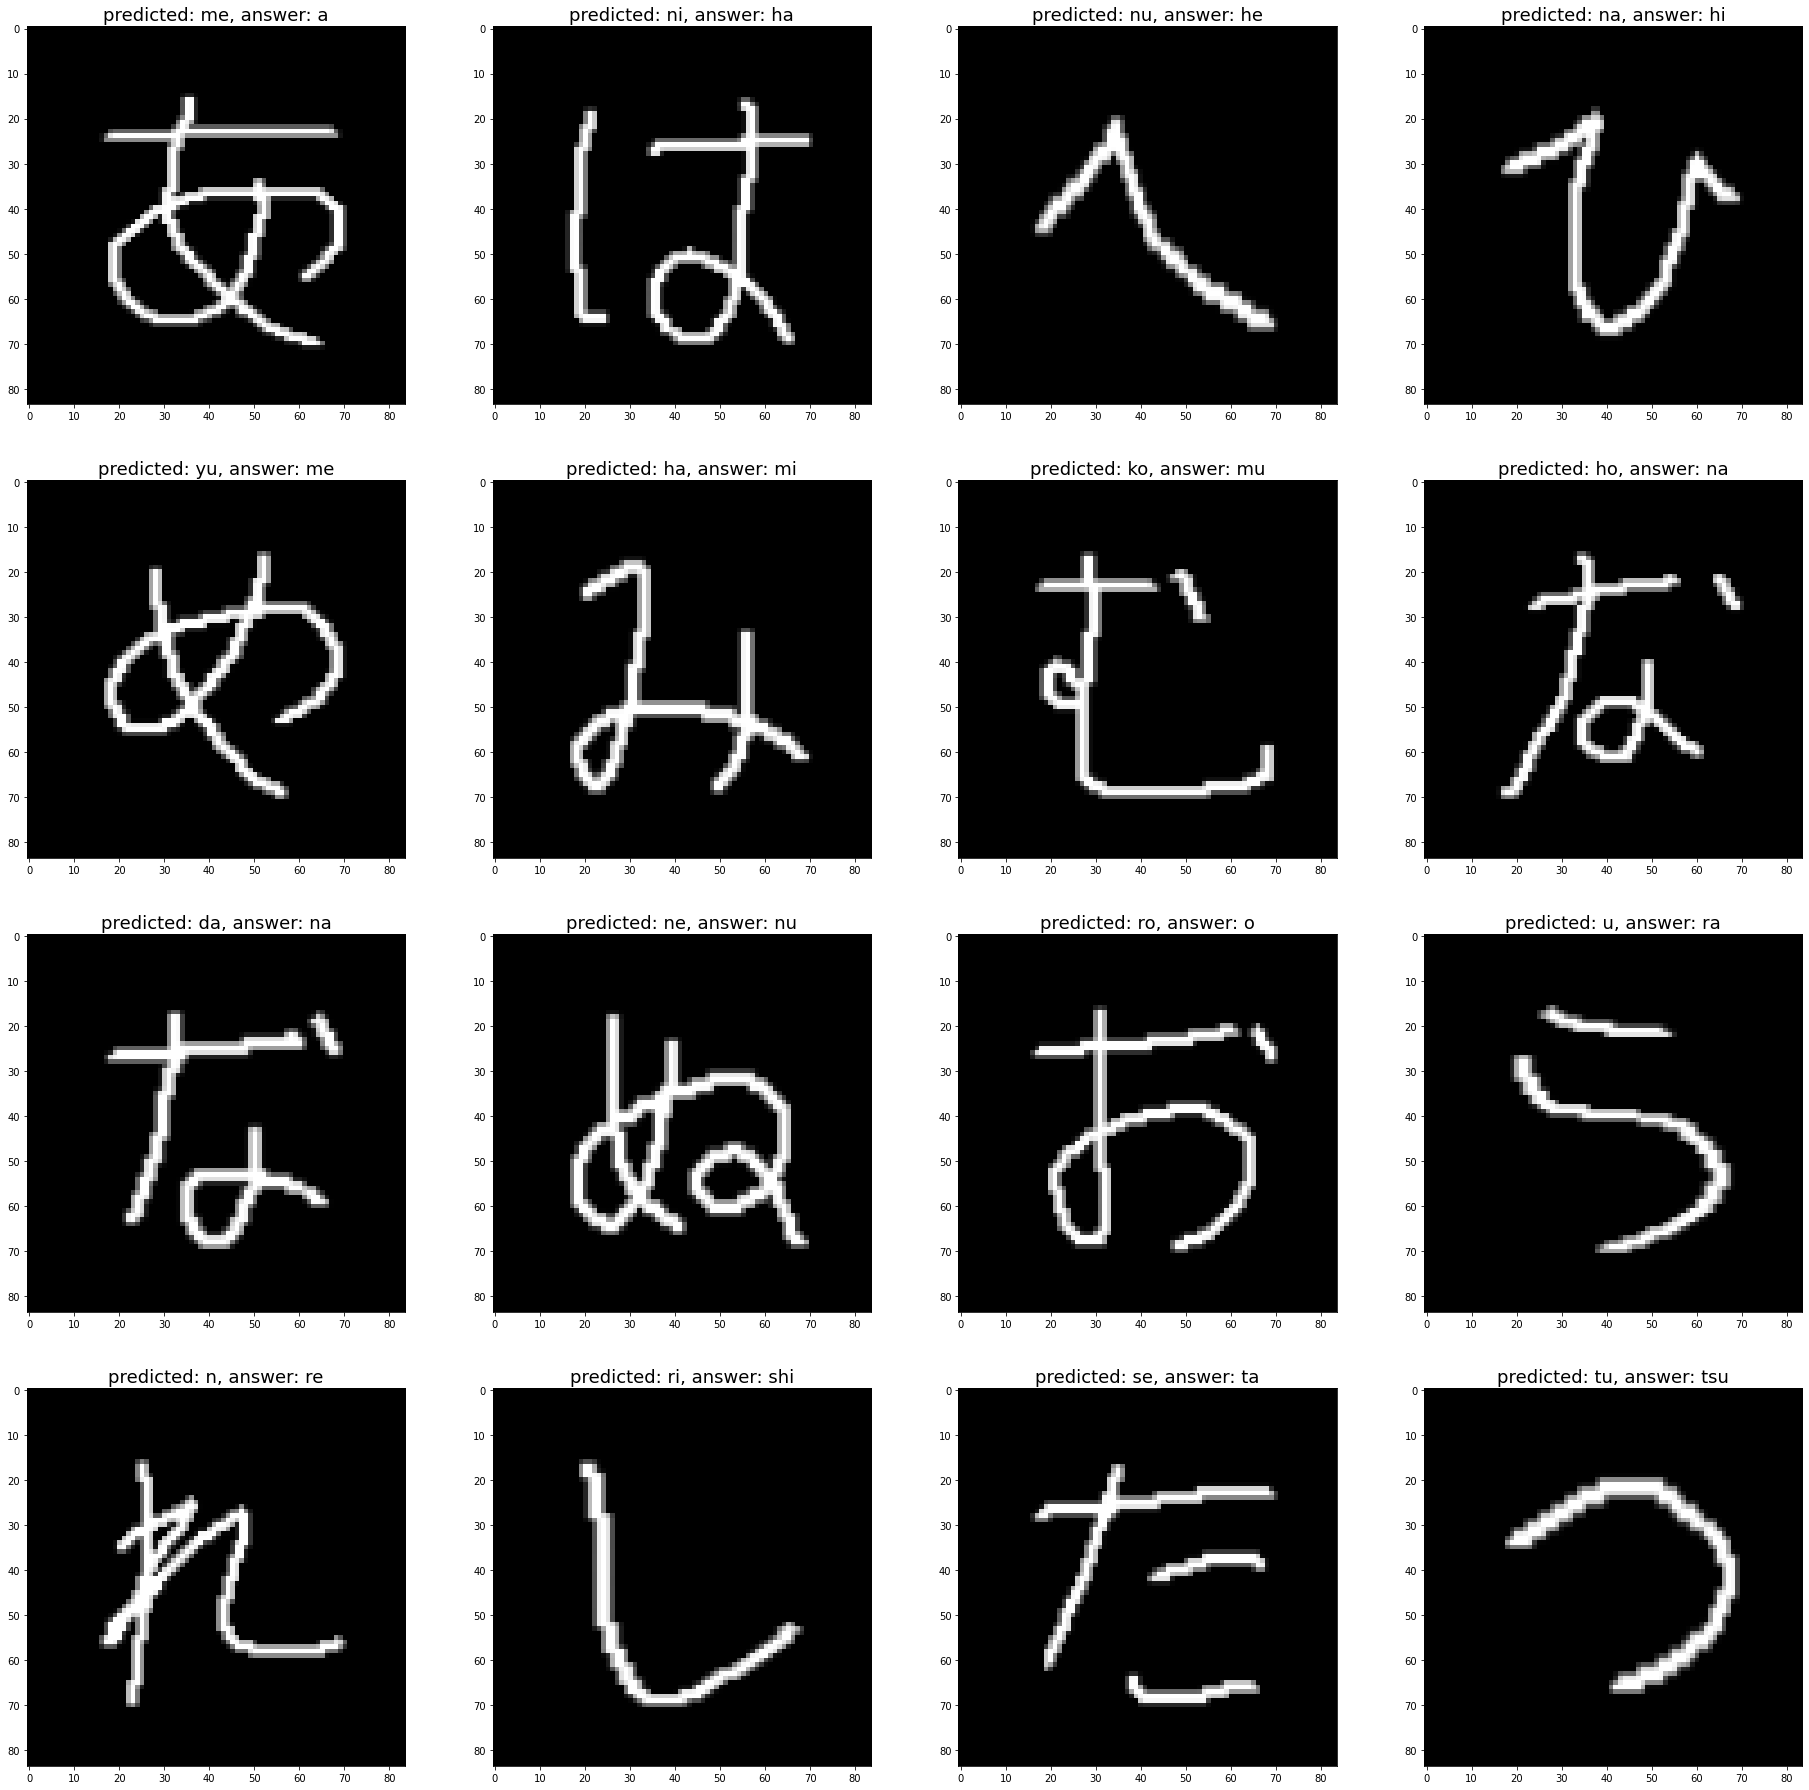

In [129]:
num_myhw = len(my_handwritings)
my_handwritings = my_handwritings.reshape(num_myhw, 84, 84, 1)
my_handwritings = std_X(my_handwritings)
print(my_handwritings.shape)
prob_myhw = model.predict(my_handwritings)
predictions_myhw = np.argmax(prob_myhw,axis=1)
# print(predictions_myhw)
prediction_romanji_myhw = [inv_romanji_dict[prediction] for prediction in predictions_myhw]
# print(prediction_romanji_myhw)
# print(answers_myhw)

errors_myhw = []
for i in range(num_myhw):
    if prediction_romanji_myhw[i] != answers_myhw[i]:
        errors_myhw.append(i)
# print(errors_myhw)
num_err_myhw = len(errors_myhw)
print("Number of errors_myhw = {}/{}".format(num_err_myhw,num_myhw))
print("Accuracy: {:.2f}".format(1-num_err_myhw/num_myhw))

num_eachrow = 4
rows_err = math.ceil(num_err_myhw / num_eachrow)
fig, axes = plt.subplots(rows_err, num_eachrow, figsize=(8*num_eachrow,8*rows_err))
for r in range(rows_err):
    for c in range(num_eachrow):
        n_err = r * num_eachrow + c
        if n_err >= num_err_myhw: break
        pos_err = errors_myhw[n_err]
        # plt.title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}")
        axes[r,c].set_title(f"predicted: {prediction_romanji_myhw[pos_err]}, answer: {answers_myhw[pos_err]}", fontsize=18)
        axes[r,c].imshow(my_handwritings[pos_err], cmap=plt.get_cmap('gray'))

Save the model

In [132]:
# from keras.models import load_model
# # creates a HDF5 file
# model.save('model_hiragana_recognition_cnn.h5') 
